# セットアップ

In [1]:
# 使用モジュールをインポート
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# データの前処理

## データの取得

In [2]:
# ファイルを取得して、パスを通す
Asian = "/content/drive/MyDrive/lab/論文発表/Asian"
japan_dir = os.path.join(Asian, "Japan")
njapan_dir = os.path.join(Asian, "Not_Japan")

**Asian**

|__ **Japan**: [img00001.jpg, img00002.jpg, img00003.jpg ...]

|__ **Not_Japan**: [img24001.jpg, img24002.jpg, img24003 ...]

In [3]:
# バッチサイズ、画像サイズの決定
BATCH_SIZE = 64
IMG_SIZE = (160, 160)

In [4]:
# データセットの作成
train_dataset = image_dataset_from_directory(Asian, shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 6920 files belonging to 2 classes.


In [5]:
# クラス名を与える
class_names = train_dataset.class_names

## データを分割する

In [6]:
# train_datasetからテスト・検証用データを作る

# trainのバッチサイズを取得
train_batches = tf.data.experimental.cardinality(train_dataset)

# trainの半分のバッチををvalidationに移す
validation_dataset = train_dataset.take(train_batches // 2)
train_batches = train_dataset.skip(train_batches // 2)

# validation_datasetの20％のバッチをtestに移す
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_batches = validation_dataset.skip(val_batches // 5)

In [7]:
# データの送受信を効率化
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# モデル構築

In [8]:
# データ拡張層
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
# MobileNetV2に入力できるよう変形する層
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
# 画像サイズの指定
IMG_SHAPE = IMG_SIZE + (3,)

# ベースモデル作成
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
# バッチサイズの取得
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [12]:
# ベースモデルの学習を無効化
base_model.trainable = False

In [13]:
# ベースモデルのアーキテクチャ確認
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [14]:
# pooling層
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [15]:
# 2値分類を行う全結合層
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [16]:
# 層をチェーン化してモデルを作る
inputs = tf.keras.Input(shape=(160, 160, 3))  # 入力
x = data_augmentation(inputs) # データ拡張
x = preprocess_input(x) # データの前処理
x = base_model(x, training=False) #ベースモデル
x = global_average_layer(x) # プーリング層
x = tf.keras.layers.Dropout(0.2)(x) # ドロップアウト
outputs = prediction_layer(x) # 全結合層、出力
model = tf.keras.Model(inputs, outputs) # モデル

In [17]:
# モデルコンパイル
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
# モデル訓練
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
109/109 [==============================] - 835s 8s/step - loss: 0.6401 - accuracy: 0.6129 - val_loss: 0.5297 - val_accuracy: 0.7491
Epoch 2/10
109/109 [==============================] - 58s 511ms/step - loss: 0.5018 - accuracy: 0.7348 - val_loss: 0.4575 - val_accuracy: 0.7801
Epoch 3/10
109/109 [==============================] - 59s 517ms/step - loss: 0.4587 - accuracy: 0.7645 - val_loss: 0.4249 - val_accuracy: 0.7951
Epoch 4/10
109/109 [==============================] - 59s 515ms/step - loss: 0.4375 - accuracy: 0.7847 - val_loss: 0.4071 - val_accuracy: 0.8012
Epoch 5/10
109/109 [==============================] - 59s 522ms/step - loss: 0.4282 - accuracy: 0.7860 - val_loss: 0.3992 - val_accuracy: 0.8056
Epoch 6/10
109/109 [==============================] - 60s 524ms/step - loss: 0.4103 - accuracy: 0.7887 - val_loss: 0.3851 - val_accuracy: 0.8096
Epoch 7/10
109/109 [==============================] - 58s 515ms/step - loss: 0.4035 - accuracy: 0.7964 - val_loss: 0.3813 - val_accu

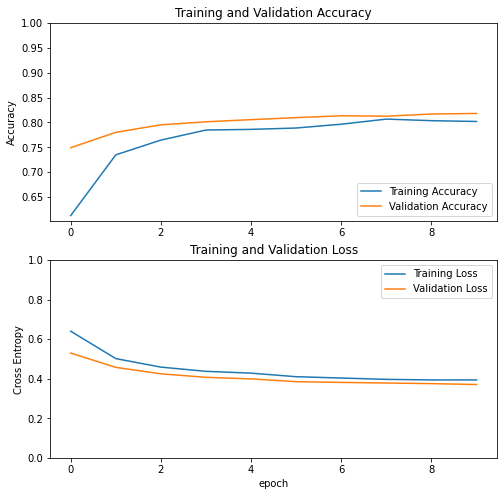

In [19]:
# 学習の様子
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# fine-tuning

In [20]:
# ベースモデルのフリーズ解除
base_model.trainable = True

In [21]:
# ベースモデルにある層の数を確認
print("Number of layers in the base model: ", len(base_model.layers))

# ファインチューニングする層の数を決める（100層）
fine_tune_at = 100

# 100層以外の層はフリーズ
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [22]:
# モデルコンパイル
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
# モデルアーキテクチャ確認
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [24]:
# モデル訓練（fine-tuning）
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
109/109 [==============================] - 69s 542ms/step - loss: 0.3752 - accuracy: 0.8130 - val_loss: 0.3469 - val_accuracy: 0.8345
Epoch 11/20
109/109 [==============================] - 61s 538ms/step - loss: 0.3358 - accuracy: 0.8340 - val_loss: 0.3235 - val_accuracy: 0.8443
Epoch 12/20
109/109 [==============================] - 60s 531ms/step - loss: 0.3209 - accuracy: 0.8418 - val_loss: 0.3127 - val_accuracy: 0.8391
Epoch 13/20
109/109 [==============================] - 61s 534ms/step - loss: 0.3112 - accuracy: 0.8434 - val_loss: 0.3119 - val_accuracy: 0.8469
Epoch 14/20
109/109 [==============================] - 61s 534ms/step - loss: 0.3057 - accuracy: 0.8461 - val_loss: 0.3090 - val_accuracy: 0.8553
Epoch 15/20
109/109 [==============================] - 61s 537ms/step - loss: 0.2947 - accuracy: 0.8526 - val_loss: 0.3173 - val_accuracy: 0.8542
Epoch 16/20
109/109 [==============================] - 61s 535ms/step - loss: 0.2911 - accuracy: 0.8504 - val_loss: 0.3221 -

In [25]:
# fine-tuning後のacc, val_acc, loss, val_loss
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

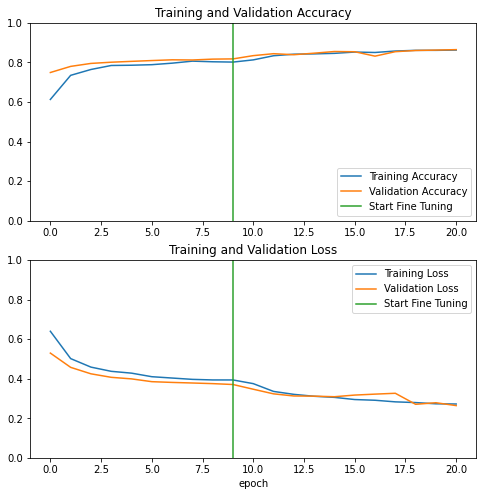

In [26]:
# 学習の様子をプロット
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# モデルの評価

In [27]:
# loss, accuracyを見てみる
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

10/10 [==============================] - 6s 350ms/step - loss: 0.2855 - accuracy: 0.8656
Test accuracy : 0.8656250238418579


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1]
Labels:
 [1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1]


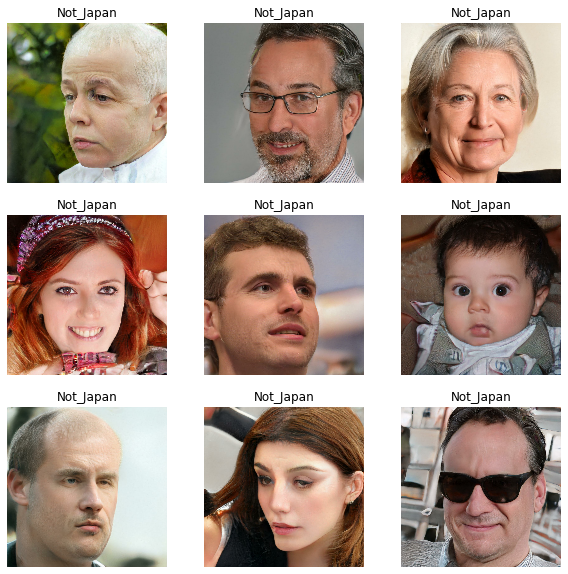

In [28]:
# バッチサイズの取得
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# モデルによる予測
predictions = model.predict_on_batch(image_batch).flatten()

# ロジット関数をシグモイドに変換
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# 学習済みモデルの保存

In [29]:
# 保存先のパスを指定する
export_path = "/content/drive/MyDrive/lab/論文発表/{}".format("日本人識別")

# モデルの保存
model.save(export_path, save_format='tf')

# 保存先を参照する
export_path

INFO:tensorflow:Assets written to: /content/drive/MyDrive/lab/論文発表/日本人識別/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


'/content/drive/MyDrive/lab/論文発表/日本人識別'

In [30]:
# 保存したモデルを呼び出す
reloaded = tf.keras.models.load_model(export_path)